<span style="font-size:16pt">
<p style="text-align: center;">
    МИНОБРНАУКИ РОССИИ <br>
    РГУ НЕФТИ И ГАЗА (НИУ) ИМЕНИ И.М. ГУБКИНА<br>
    ФАКУЛЬТЕТ АВТОМАТИКИ И ВЫЧИСЛИТЕЛЬНОЙ ТЕХНИКИ<br>
    КАФЕДРА АВТОМАТИЗИРОВАННЫХ СИСТЕМ УПРАВЛЕНИЯ<br>  <br>
    ДИСЦИПЛИНА <br>
        «Теория принятия решений. Нечеткие модели»
    <br><br> <br> <br> <br> <br>
    ОТЧЁТ <br>
    по лабораторной работе №4 <br>
    «Нечёткий лес<br> <br> <br> <br> <br>  <br><br>
</p>

<p style="text-align: right;">
    Выполнил:<br>
    студент группы АС-21-05, Негробов В.А.<br>
    Проверил:<br>
    Манзюк Н.Ю.<br><br> <br> <br> <br> <br><br> <br> <br>

<p style="text-align: center;">
    МОСКВА 2025
</p>
   </span>

In [211]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numba as nb

Дерево решений – широко известный и популярный метод автоматического анализа данных, в основе которого лежит обучение на примерах. Правила представлены в виде иерархической последовательной структуры, где каждый объект принадлежит конкретному узлу.

Однако может возникнуть случай, когда точно классифицировать объект по тому или иному признаку довольно трудно. Эти ситуации разрешаются благодаря возможностям нечеткой логики, когда говорят не просто о принадлежности к кому-то классу, признаку, атрибуту, а о её степени. При использовании нечетких деревьев решений (fuzzy decision trees) не теряются знания о том, что объект может обладать свойствами как одного признака, так и другого в той или иной мере.

Главной идеей в таком подходе является сочетание возможностей деревьев решений и нечеткой логики.

Отличительной чертой деревьев решений является то, что каждый пример определенно принадлежит конкретному узлу. В нечетком случае это не так. Для каждого атрибута необходимо выделить несколько его лингвистических значений и определить степени принадлежности примеров к ним. Вместо количества примеров конкретного узла нечеткое дерево решений группирует их степень принадлежности. Коэффициент – это соотношение примеров Dj∈SN
 узла N
 для целевого значения i
, вычисляемый как:

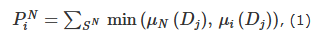

где $\mu_N(D_j)$
 – степень принадлежности примера Dj
 к узлу N
, $\mu_i(D_j)$
 – степень принадлежности примера относительно целевого значения i
, $S_N$
 – множество всех примеров узла N
. Затем находим коэффициент $P_N$
, обозначающий общие характеристики примеров узла N
. В стандартном алгоритме дерева решений определяется отношение числа примеров, принадлежащих конкретному атрибуту, к общему числу примеров. Для нечетких деревьев используется отношение $\frac{{P_i}^N}{P^N}$
, для расчета которого учитывается степень принадлежности.

In [212]:
class FuzzyDecisionTree:
    def __init__(self, max_depth=3, min_samples_split=2, k=10):
        """
        max_depth: максимальная глубина дерева
        min_samples_split: минимальное число образцов для разбиения узла
        k: параметр, определяющий «размытие» разделения (чем больше k, тем резче разделение)
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.k = k
        self.tree = None

    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        data = np.hstack([X, y.reshape(-1,1)])
        self.tree = self._build_tree(data, depth=0)

    @staticmethod
    def get_candidate_thresholds(values):
        return (values[:-1] + values[1:]) / 2
    
    @staticmethod
    def calculate_fuzzy_weights(feature_values, threshold, k):
        left_weights = 1 / (1 + np.exp(k * (feature_values - threshold)))
        right_weights = 1 - left_weights
        return left_weights, right_weights
    
    @staticmethod
    def calculate_weighted_impurity(left_distribution, right_distribution, left_total, right_total):
        impurity_left = 1 - np.sum((np.array(left_distribution)/left_total)**2) if left_total > 0 else 0
        impurity_right = 1 - np.sum((np.array(right_distribution)/right_total)**2) if right_total > 0 else 0

        return (left_total * impurity_left + right_total * impurity_right) / (left_total + right_total)


    def _build_tree(self, data, depth):
        # Если достигнута максимальная глубина или слишком мало образцов, создаём лист
        if depth == self.max_depth or len(data) < self.min_samples_split:
            distribution = {}
            for c in np.unique(data[:,-1]):
                distribution[c] = np.mean(data[:,-1] == c)
            return {'is_leaf': True, 'class_distribution': distribution}

        best_feature = None
        best_threshold = None
        best_impurity = np.inf
        best_split = None

        n_features = data.shape[1] - 1
        # Перебор всех признаков и кандидатов для порога
        for feature in range(n_features):
            values = data[:, feature]
            unique_vals = np.unique(values)
            if len(unique_vals) == 1:
                continue
            # Используем средние точки между отсортированными уникальными значениями
            candidate_thresholds = self.get_candidate_thresholds(unique_vals)
            for threshold in candidate_thresholds:
                # Вычисляем степень принадлежности к левой ветке с помощью сигмоидальной функции
                left_weights, right_weights = self.calculate_fuzzy_weights(data[:, feature], threshold, self.k)

                total_left = np.sum(left_weights)
                total_right = np.sum(right_weights)
                if total_left < 1e-6 or total_right < 1e-6:
                    continue

                # Расчёт нечеткой (взвешенной) классификации для каждой ветки
                left_distribution = {}
                right_distribution = {}
                for c in range(self.n_classes):
                    mask = (data[:,-1] == c)
                    w_left = np.sum(left_weights[mask])
                    w_right = np.sum(right_weights[mask])
                    left_distribution[c] = w_left
                    right_distribution[c] = w_right

                left_total = np.sum(list(left_distribution.values()))
                right_total = np.sum(list(right_distribution.values()))


                weighted_impurity = self.calculate_weighted_impurity(list(left_distribution.values()), list(right_distribution.values()), left_total, right_total)
                if weighted_impurity < best_impurity:
                    best_impurity = weighted_impurity
                    best_feature = feature
                    best_threshold = threshold
                    best_split = (left_weights, right_weights)

        # Если не найдено подходящего разбиения, создаём лист
        if best_feature is None:
            distribution = {}
            for c in np.unique(data[:,-1]):
                distribution[c] = np.mean(data[:,-1] == c)
            return {'is_leaf': True, 'class_distribution': distribution}

        # "Жёсткое" разбиение: каждый объект идёт в ту ветку, к которой у него степень принадлежности больше
        crisp_assignments = best_split[0] >= best_split[1]
        left_data = data[crisp_assignments]
        right_data = data[~crisp_assignments]

        left_tree = self._build_tree(left_data, depth+1)
        right_tree = self._build_tree(right_data, depth+1)
        return {
            'is_leaf': False,
            'feature': best_feature,
            'threshold': best_threshold,
            'left': left_tree,
            'right': right_tree
        }

    def _predict_sample(self, x, node):
        # Рекурсивный проход по дереву
        if node['is_leaf']:
            return node['class_distribution']
        feature = node['feature']
        threshold = node['threshold']
        left_weight = 1 / (1 + np.exp(self.k * (x[feature] - threshold)))
        right_weight = 1 - left_weight
        left_pred = self._predict_sample(x, node['left'])
        right_pred = self._predict_sample(x, node['right'])
        # Агрегация предсказаний с учётом нечетких весов
        combined = {}
        for c in range(self.n_classes):
            combined[c] = left_weight * left_pred.get(c, 0) + right_weight * right_pred.get(c, 0)
        return combined

    def predict(self, X):
        preds = []
        for i in range(X.shape[0]):
            distribution = self._predict_sample(X[i], self.tree)
            pred_class = max(distribution, key=distribution.get)
            preds.append(pred_class)
        return np.array(preds)

In [213]:
class FuzzyRandomForest:
    def __init__(self, n_estimators=10, max_depth=3, min_samples_split=2, k=10):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.k = k
        self.trees = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        for i in range(self.n_estimators):
            # Bootstrap-подвыборка
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            tree = FuzzyDecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                k=self.k
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = []
        for tree in self.trees:
            predictions.append(tree.predict(X))
        predictions = np.array(predictions)  # форма (n_estimators, n_samples)
        final_predictions, _ = mode(predictions, axis=0)
        return final_predictions.flatten()

In [214]:
def print_tree(node, indent=""):
    """
    Рекурсивная печать структуры дерева в консоль.
    """
    if node['is_leaf']:
        print(indent + "Лист:", {k: float(round(v, 2))
                                 for k, v in node['class_distribution'].items()})
    else:
        print(indent + f"Разбиение: feature[{node['feature']}] < {node['threshold']:.2f}")
        print(indent + " -> Левая ветка:")
        print_tree(node['left'], indent + "  ")
        print(indent + " -> Правая ветка:")
        print_tree(node['right'], indent + "  ")

In [215]:
data_path = r'data\WineQT.csv'
target_var = 'quality'
df = pd.read_csv(data_path, index_col='Id')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1592,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1593,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5


<Axes: >

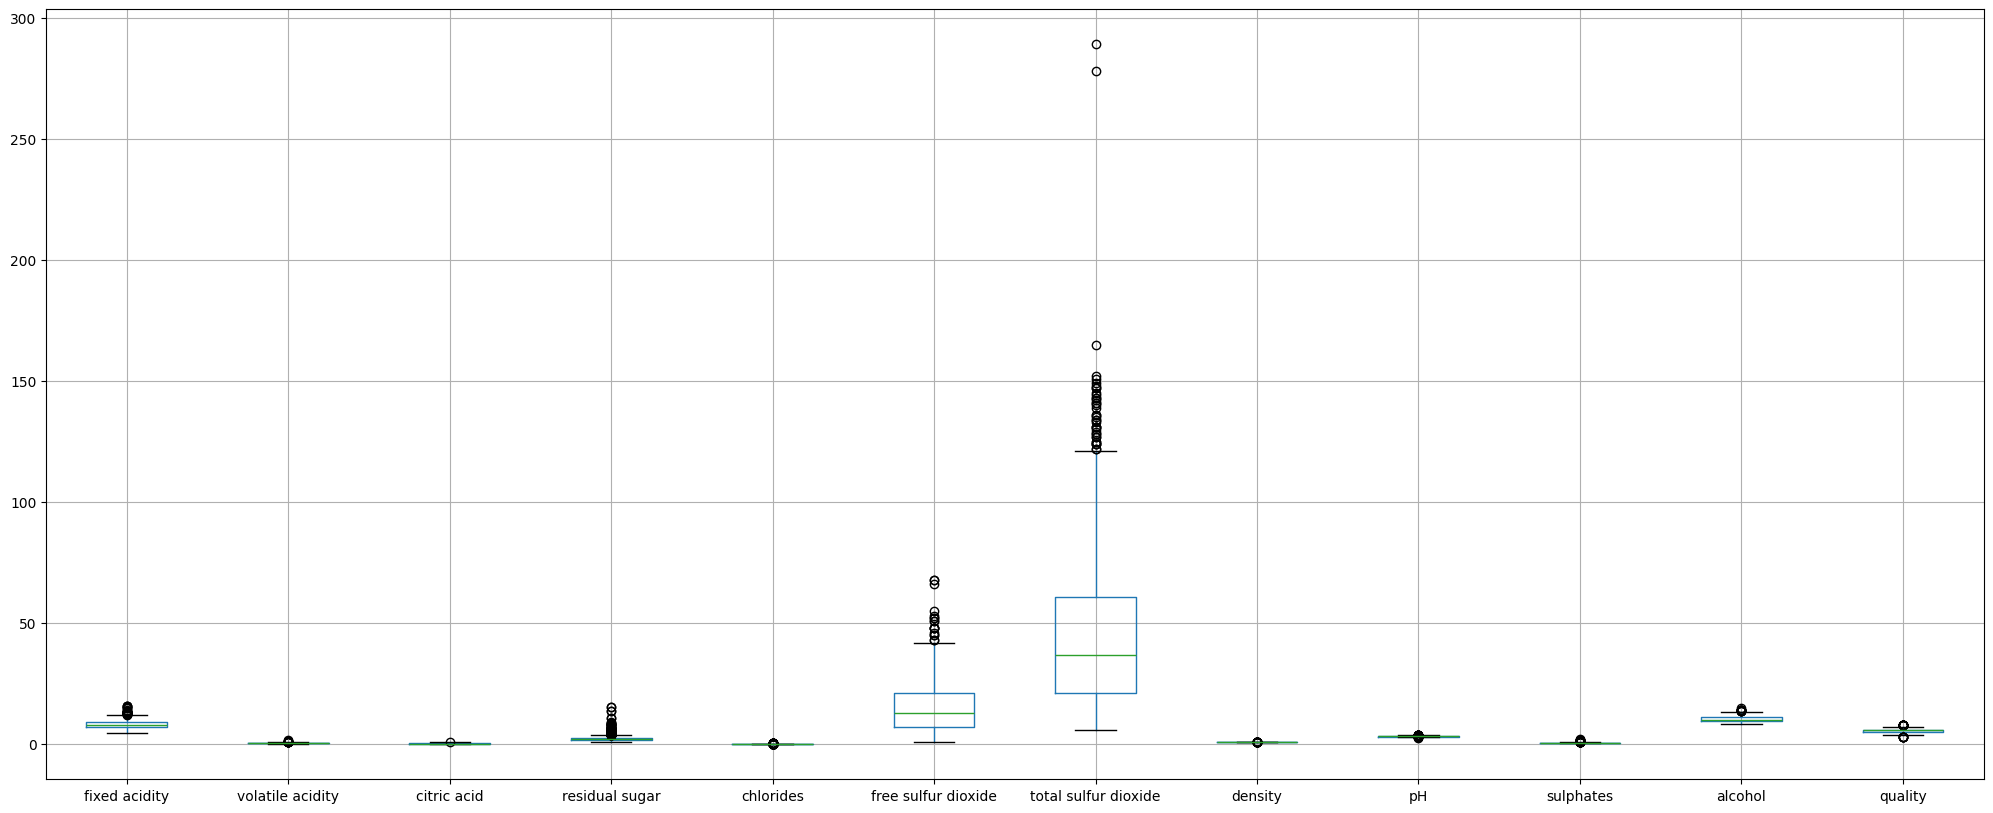

In [216]:
plt.figure(figsize=(25, 10))
df.boxplot()

<Axes: xlabel='quality', ylabel='Count'>

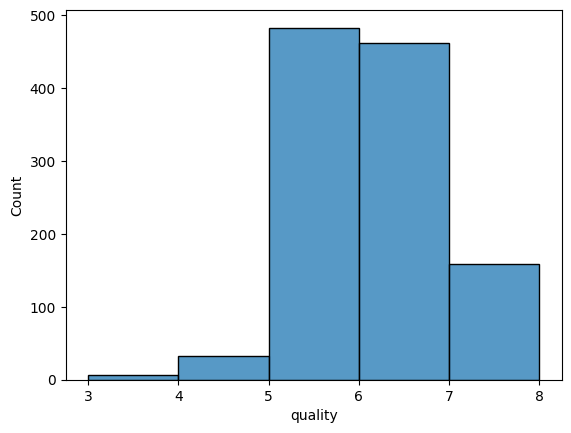

In [217]:
sns.histplot(data=df, x=target_var, fill=True, binwidth=1)

In [218]:
X = df.drop(target_var, axis=1).values
y = df[target_var].values
X.shape, y.shape

((1143, 11), (1143,))

In [219]:
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

<Axes: ylabel='Count'>

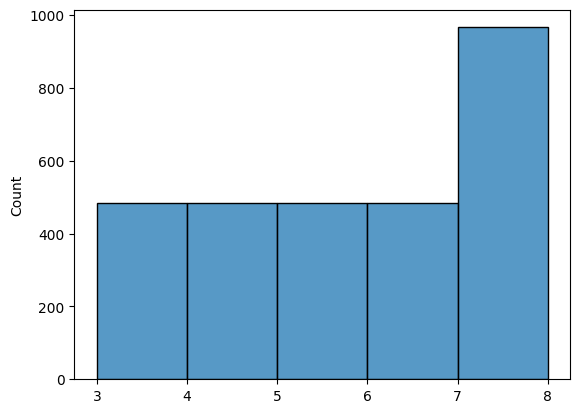

In [220]:
sns.histplot(y, fill=True, binwidth=1)

In [221]:
le = LabelEncoder()
y = le.fit_transform(y)
y.min(), y.max()

(np.int64(0), np.int64(5))

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2318, 11), (580, 11), (2318,), (580,))

Чёткий случайный лес

In [223]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

In [224]:
accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(1.0, 0.8637931034482759)

In [225]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       386
           1       1.00      1.00      1.00       391
           2       1.00      1.00      1.00       375
           3       1.00      1.00      1.00       388
           4       1.00      1.00      1.00       387
           5       1.00      1.00      1.00       391

    accuracy                           1.00      2318
   macro avg       1.00      1.00      1.00      2318
weighted avg       1.00      1.00      1.00      2318



In [226]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1       0.92      0.97      0.94        92
           2       0.79      0.69      0.74       108
           3       0.67      0.61      0.64        95
           4       0.82      0.97      0.89        96
           5       0.99      0.97      0.98        92

    accuracy                           0.86       580
   macro avg       0.86      0.87      0.86       580
weighted avg       0.86      0.86      0.86       580



Нечёткий случайный лес

In [227]:
forest = FuzzyRandomForest(
    n_estimators=10,
    max_depth=3,
    min_samples_split=10,
    k=2
)

forest.fit(X_train, y_train)

In [228]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

In [229]:
accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(0.45211389128559104, 0.45)

In [230]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.40      0.97      0.57       386
           1       0.40      0.16      0.23       391
           2       0.54      0.41      0.47       375
           3       0.61      0.03      0.05       388
           4       0.39      0.55      0.46       387
           5       0.63      0.59      0.61       391

    accuracy                           0.45      2318
   macro avg       0.49      0.45      0.40      2318
weighted avg       0.49      0.45      0.40      2318



In [231]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.38      0.94      0.54        97
           1       0.42      0.22      0.29        92
           2       0.57      0.39      0.46       108
           3       0.50      0.05      0.10        95
           4       0.42      0.56      0.48        96
           5       0.64      0.53      0.58        92

    accuracy                           0.45       580
   macro avg       0.49      0.45      0.41       580
weighted avg       0.49      0.45      0.41       580



In [232]:
print_tree(forest.trees[0].tree)

Разбиение: feature[10] < 10.89
 -> Левая ветка:
  Разбиение: feature[6] < 50.85
   -> Левая ветка:
    Разбиение: feature[5] < 22.24
     -> Левая ветка:
      Лист: {np.float64(0.0): 0.39, np.float64(1.0): 0.16, np.float64(2.0): 0.17, np.float64(3.0): 0.14, np.float64(4.0): 0.08, np.float64(5.0): 0.06}
     -> Правая ветка:
      Лист: {np.float64(1.0): 0.6, np.float64(2.0): 0.16, np.float64(3.0): 0.19, np.float64(4.0): 0.05}
   -> Правая ветка:
    Разбиение: feature[6] < 105.55
     -> Левая ветка:
      Лист: {np.float64(1.0): 0.31, np.float64(2.0): 0.41, np.float64(3.0): 0.27, np.float64(4.0): 0.01}
     -> Правая ветка:
      Лист: {np.float64(1.0): 0.05, np.float64(2.0): 0.92, np.float64(3.0): 0.03}
 -> Правая ветка:
  Разбиение: feature[5] < 8.37
   -> Левая ветка:
    Разбиение: feature[6] < 11.50
     -> Левая ветка:
      Лист: {np.float64(0.0): 0.01, np.float64(1.0): 0.35, np.float64(2.0): 0.07, np.float64(3.0): 0.22, np.float64(4.0): 0.35}
     -> Правая ветка:
      Лист: